In [ ]:
# Install the college football data api
# https://github.com/CFBD/cfbd-python
!pip install cfbd

In [ ]:
# The problem: You are a football coach, and you want to know whether or not a run play 
# or pass play will be succesful given the situation you are in. YOu know that certain opponents are stronger than others
# and that your team has not been doing well. In this problem, we will determine whether or not a run play or pass would be successful
# given the situation

# Example: Georgia Tech vs. Virginia Tech
# Situation: 1st and 10 on the 25 yard line, 75 yards to go, 5 minutes left to go in the first quarter. 
# Call run play or pass (throwing football) play?
# Start with binary: -1 (failure), 1 (success) [NB, NN]
# Try 4: -2 (very bad), -1 (bad), 1 (good), 2 (very good) [NB, NN]
# Try 6: -3 (horrible, pick six), -2 (very bad, interception/fumble), -1 (bad, lost yards), 1 (good, 10 yards),
# 2 (very good, big game), 3 (best, touchdown) [NB, NN]

In [ ]:
# Necessary imports
import cfbd
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set up the API access
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = "UIJ0zjCWpI/TbPN1yO/ykcCd+dnv+Hh3tUyRHPYPhg/c+aRj2gpvjq3TZgRMmP4J"
configuration.api_key_prefix['Authorization'] = "Bearer"

apiClient = cfbd.ApiClient(configuration)

In [ ]:
# Get all the teams (as well as relavent offensive and defensive statistics)
allTeams = cfbd.api.TeamsApi(apiClient)
teams = allTeams.get_fbs_teams()

allRatings = cfbd.api.RatingsApi(apiClient)
sp_ratings = allRatings.get_sp_ratings(year=2021)

allMetrics = cfbd.api.MetricsApi(apiClient)

TEAM_INDEX = {}
TEAM_RATING = {}
TEAM_OFFENSE = {}
TEAM_DEFENSE = {}

for n, data in enumerate(teams):
    TEAM_INDEX[data.school] = n

for n, data in enumerate(sp_ratings):
    TEAM_RATING[data.team] = data.rating
    TEAM_OFFENSE[data.team] = data.offense['rating']
    TEAM_DEFENSE[data.team] = data.defense['rating']

print(TEAM_RATING['Georgia Tech'])
print(TEAM_OFFENSE['Georgia Tech'])
print(TEAM_DEFENSE['Georgia Tech'])

print(TEAM_RATING['Georgia'])
print(TEAM_OFFENSE['Georgia'])
print(TEAM_DEFENSE['Georgia'])

-5.8
27.4
32.1
31.7
41.1
10.5


In [ ]:
# offense_is_home = (plays.offense == play.home)
# plays.period, plays.clock['minutes'], plays.clock['seconds'] (Time left on clock)
# Score differential: plays.offense_score - plays.defense_score
# plays.down, plays.distance, plays.yards_to_go (1st and 10, 75 yards to go)
# TWO FEATURES: ppa < 0 (Bad) ppa >= 0 (Good)
# FOUR FEATURES: ppa <= -2 (Very Bad), ppa < 0 (Bad), ppa > 0 (Good), ppa >= 2 (Good)
# SIX FEATURES: ppa <= -3 (Horrible), -2 (Very Bad), 0 (Bad), 0 (Good), 2 (Very Good), 3 (Excellent)
# Play Type = 'Pass Incompletion' (PASS), 

# If ppa data doesn't exist for a play => ppa rules
# TOUCHDOWN: 1, 2, 3
# 1st down: 1, 1, 2
# Successful play: 1, 1, 1
# No gain: -1, -1, -1
# Lost yardage: -1, -1, -2
# Sack: -1, -2, -3
# Punt: -1, -1, -2
# Pick Six/Scoop and Score: -1, -2, -3

# plays.play_type
# Run = 'Rush', 'Rushing Touchdown', 'Fumble Recovery (Own), 'Fumble Recovery (Opponent)',
# 'Fumble Return Touchdown'
# Pass = 'Pass Reception', 'Pass Incompletion', 'Sack', 'Passing Touchdown',
# 'Pass Interception Return', 'Interception Return Touchdown'
rushes = ['Rush', 'Rushing Touchdown', 'Fumble Recovery (Own)', 'Fumble Recovery (Opponent)', 'Fumble Return Touchdown']
passes = ['Pass Reception', 'Pass Incompletion', 'Sack', 'Passing Touchdown', 'Pass Interception Return', 'Interception Return Touchdown']
successful = ['Rushing Touchdown', 'Passing Touchdown']
failure = ['Fumble Recovery (Opponent)', 'Fumble Return Touchdown', 'Pass Incompletion', 'Sack', \
           'Pass Interception Return', 'Interception Return Touchdown']

In [ ]:
# Get the play-by-play data (Only need to run once)
allPlays = cfbd.api.PlaysApi(apiClient)

X = []
Y = []

for w in range(1, 14):
    plays = allPlays.get_plays(year=2021, week=w)
    for i in range(len(plays)):
        play = plays[i]
        # Determine play_type (0 or 1) [0 = rush, 1 = pass]
        play_type = play.play_type
        if play_type in rushes:
            is_pass = 0
        elif play_type in passes:
            is_pass = 1
        else:
            continue
        # Quarter of game
        quarter = play.period
        # Determine time left in quarter (in minutes)
        time_left = play.clock['minutes'] + play.clock['seconds'] / 60.0
        # Score differential
        score_diff = play.offense_score - play.defense_score
        # Determine the down
        down = play.down
        # Determine the distance
        dist = play.distance
        # Determine the yards to go
        yards = play.yards_to_goal
        # Determine the offensive efficiency of offense
        offense = play.offense
        if offense not in TEAM_INDEX.keys():
            continue
        off_rating = TEAM_OFFENSE[offense]
        # Determine the defensive efficiency of defense
        defense = play.defense
        if defense not in TEAM_INDEX.keys():
            continue
        def_rating = TEAM_DEFENSE[defense]
        # Is the offense at home
        if offense == play.home:
            is_home = 1
        else:
            is_home = 0

        ppa = play.ppa

        if ppa is None:
            continue
        else:
            if ppa > 0:
                success = 1
            else:
                success = 0
        
        X.append([is_pass, quarter / 4.0, time_left / 15.0, score_diff / 7.0, down / 4.0, dist / 10.0, yards / 100.0, off_rating / 50.0, def_rating / 50.0, is_home])
        Y.append([success])

np.save('/content/drive/My Drive/Colab Notebooks/features.npy', X)
np.save('/content/drive/My Drive/Colab Notebooks/labels.npy', Y)

NameError: ignored

In [ ]:
X = np.load('/content/drive/My Drive/Colab Notebooks/features.npy')
Y = np.load('/content/drive/My Drive/Colab Notebooks/labels.npy')

ndata = len(X)
nfeat = len(X[0])

# X2 and Y2 are for logistic regression
X2 = np.zeros((ndata, nfeat+1))
for i in range(ndata):
    X2[i,:nfeat] = np.array(X[i], dtype='float64')
    X2[i,nfeat] = 1

Y2 = np.array(Y, dtype='int32').flatten()
for i in range(len(Y2)):
    if Y2[i] == 0:
        Y2[i] = -1
        
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2)

In [ ]:
# Logistic regression (Code from Project 2 (Linear Models, BASELINE))
def LogisticLoss(X, Y, W, lmda):
    #TODO: Compute (regularized) Logistic Loss
    ndata = X.shape[0]
    loss_vector = np.log(1.0 + np.exp(-Y * X.dot(W)))
    loss = np.sum(loss_vector) + lmda * W.dot(W)
    return loss

# Returns the gradient for a single training example
def LogisticGradient(Xl, Yl, W, lmda):
    power = -Yl * np.dot(W, Xl)
    grad = -Yl * np.exp(power) / (1.0 + np.exp(power)) * Xl + 2.0 * lmda * W
    return grad

def SgdLogistic(X, Y, maxIter, learningRate, lmda):
    ndata, nfeat = X.shape[0], X.shape[1]
    W = np.zeros(nfeat)
    #TODO: implement stochastic gradient descent using the logistic loss function
    for iter in range(maxIter):
        for l in range(ndata):
            W -= learningRate * LogisticGradient(X[l], Y[l], W, lmda)
        loss = LogisticLoss(X, Y, W, lmda)
        print(f"EPOCH: {iter}, LOSS: {loss:.4f}")
    return W

def EvalWeights(X, Y, W):
    nCorrect, nIncorrect = 0, 0
    for i in range(len(X)):
        y_hat = np.sign(X[i].dot(W))
        if y_hat == 0.0:
            y_hat = -1.0

        if y_hat == Y[i]:
            nCorrect += 1
        else:
            nIncorrect += 1
    return nCorrect / (nCorrect + nIncorrect)

def EvalNeg(X, Y):
    numCorrect = 0
    for i in range(len(X)):
        if Y[i] == -1:
            numCorrect += 1
    return numCorrect / len(X)

In [ ]:
W = SgdLogistic(X2_train, Y2_train, maxIter=20, learningRate=1e-3, lmda=0.0)
base_train = EvalNeg(X2_train, Y2_train)
acc_train = EvalWeights(X2_train, Y2_train, W)
print(f'BaseTrain: {base_train:.4f}')
print(f'BaseAccuracy: {acc_train:.4f}')
base = EvalNeg(X2_test, Y2_test)
acc = EvalWeights(X2_test, Y2_test, W)
print(f'Base: {base:.4f}')
print(f'Accuracy: {acc:.4f}')

EPOCH: 0, LOSS: 51801.4909
EPOCH: 1, LOSS: 51724.9379
EPOCH: 2, LOSS: 51670.6794
EPOCH: 3, LOSS: 51629.6624
EPOCH: 4, LOSS: 51598.3537
EPOCH: 5, LOSS: 51574.3930
EPOCH: 6, LOSS: 51556.0301
EPOCH: 7, LOSS: 51541.9413
EPOCH: 8, LOSS: 51531.1206
EPOCH: 9, LOSS: 51522.8012
EPOCH: 10, LOSS: 51516.3984
EPOCH: 11, LOSS: 51511.4652
EPOCH: 12, LOSS: 51507.6600
EPOCH: 13, LOSS: 51504.7215
EPOCH: 14, LOSS: 51502.4493
EPOCH: 15, LOSS: 51500.6899
EPOCH: 16, LOSS: 51499.3257
EPOCH: 17, LOSS: 51498.2662
EPOCH: 18, LOSS: 51497.4419
EPOCH: 19, LOSS: 51496.7994
BaseTrain: 0.5438
BaseAccuracy: 0.5607
Base: 0.5458
Accuracy: 0.5634


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

with tf.device('/device:GPU:0'):
    X1 = np.array(X, dtype='float64')
    Y1 = np.array(Y, dtype='int32')

    X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2)

In [ ]:
from tensorflow.keras.callbacks import History

def make_and_train_model(Xt, Xv, Yt, Yv):
    with tf.device('/device:GPU:0'):
        input = tf.keras.layers.Input(shape=(10,), name='input')
        dense1 = tf.keras.layers.Dense(64, name='dense1',
                                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=1.0/10),
                                        bias_initializer=tf.keras.initializers.Zeros(),
                                        activation='relu')(input)
        dense2 = tf.keras.layers.Dense(16, 
                                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=1.0/64),
                                        bias_initializer=tf.keras.initializers.Zeros(),
                                        name='dense2', activation='relu')(dense1)
        output = tf.keras.layers.Dense(1,
                                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=1.0/16),
                                        bias_initializer=tf.keras.initializers.Zeros(),
                                        name='output', activation='sigmoid')(dense2)

        model = tf.keras.models.Model(inputs=input, outputs=output)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        history = History()

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        result = model.fit(Xt, Yt, validation_data=(Xv, Yv), epochs=30, batch_size=8, callbacks=[history])
    return result.history

In [ ]:
history = make_and_train_model(X1_train, X1_test, Y1_train, Y1_test)

Epoch 1/30
9443/9443 [==============================] - 29s 3ms/step - loss: 0.6832 - accuracy: 0.5624 - val_loss: 0.6805 - val_accuracy: 0.5619
Epoch 2/30
9443/9443 [==============================] - 28s 3ms/step - loss: 0.6767 - accuracy: 0.5727 - val_loss: 0.6785 - val_accuracy: 0.5642
Epoch 3/30
9443/9443 [==============================] - 28s 3ms/step - loss: 0.6743 - accuracy: 0.5753 - val_loss: 0.6760 - val_accuracy: 0.5701
Epoch 4/30
9443/9443 [==============================] - 30s 3ms/step - loss: 0.6728 - accuracy: 0.5784 - val_loss: 0.6799 - val_accuracy: 0.5674
Epoch 5/30
9443/9443 [==============================] - 28s 3ms/step - loss: 0.6716 - accuracy: 0.5791 - val_loss: 0.6765 - val_accuracy: 0.5738
Epoch 6/30
9443/9443 [==============================] - 29s 3ms/step - loss: 0.6708 - accuracy: 0.5821 - val_loss: 0.6759 - val_accuracy: 0.5758
Epoch 7/30
9443/9443 [==============================] - 30s 3ms/step - loss: 0.6703 - accuracy: 0.5818 - val_loss: 0.6744 - val_ac

In [ ]:
print(X1.shape)
print(X1_train.shape)
print(X1_test.shape)
acc = history['accuracy']
val_acc = history['val_accuracy']
print(max(acc), max(val_acc))

(94427, 10)
(75541, 10)
(18886, 10)
0.5918640494346619 0.5850895047187805


In [ ]:
import matplotlib.pyplot as plt

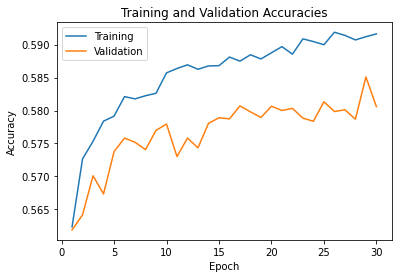

In [ ]:
epochs = list(range(1, 31))
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.legend()